In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from os import listdir
from os.path import isfile, join

train_images_path = '../input/siimacrpneumothoraxsegmentationzip-dataset/input/train/images/512/dicom'
train_masks_path = '../input/siimacrpneumothoraxsegmentationzip-dataset/input/train/images/512/mask'
train_csv = '../input/siimacrpneumothoraxsegmentationzip-dataset/input/train/train-rle.csv'

test_images_path = '../input/siimacrpneumothoraxsegmentationzip-dataset/input/test/images/512/dicom'
test_masks_path = '../input/siimacrpneumothoraxsegmentationzip-dataset/input/test/images/512/mask'

train_images = [f for f in listdir(train_images_path) if isfile(join(train_images_path,f))]
train_images.sort()
train_masks = [f for f in listdir(train_masks_path) if isfile(join(train_masks_path,f))]
train_masks.sort()
test_images = [f for f in listdir(test_images_path) if isfile(join(test_images_path,f))]
test_images.sort()
test_masks = [f for f in listdir(test_masks_path) if isfile(join(test_masks_path,f))]
test_masks.sort()

train_label = pd.read_csv(train_csv)
train_label.head()
# Any results you write to the current directory are saved as output.

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


In [2]:
import random, cv2

trains = list(zip(train_images,train_masks))
random.shuffle(trains)
train_images, train_masks = zip(*trains)

In [3]:
print(train_images[0])
print(train_masks[0])

1.2.276.0.7230010.3.1.4.8323329.14323.1517875251.285662.png
1.2.276.0.7230010.3.1.4.8323329.14323.1517875251.285662.png


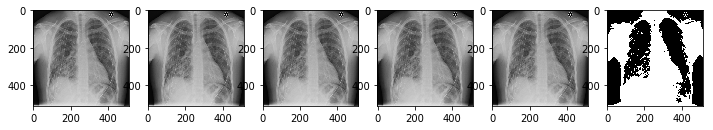

In [4]:
img = cv2.imread(train_images_path+'/'+train_images[10],cv2.IMREAD_GRAYSCALE)
img2 = img/255.
img3 = img/img.max()
img4 = (img-img.min())/(img.max()-img.min())
img5 = (img-img.mean())/img.std()
img6 = img.copy()
cv2.normalize(img,img6,0,1,cv2.NORM_MINMAX)

import matplotlib.pyplot as plt

# Check if training data looks all right
ix = random.randint(0, len(train_images))
f,ax = plt.subplots(1,6,figsize=(12,5))
ax[0].imshow(img,cmap='gray')
ax[1].imshow(img2,cmap='gray')
ax[2].imshow(img3,cmap='gray')
ax[3].imshow(img4,cmap='gray')
ax[4].imshow(img5,cmap='gray')
ax[5].imshow(img6,cmap='gray')
plt.show()

In [5]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
import keras

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [6]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

seed = 42
random.seed = seed
np.random.seed = seed

In [7]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, x, y, batch_size=32, dim=(512,512), n_channels=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.x = x
        self.y = y
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        x_list = [self.x[k] for k in indexes]
        y_list = [self.y[k] for k in indexes]

        # Generate data
        x, y = self.__data_generation(x_list,y_list)

        return x, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, x_list, y_list):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        x = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.float32)
        y = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.float32)

        # Generate data
        for i, (img,msk) in enumerate(zip(x_list,y_list)):
            # Store sample
            x[i,] = np.expand_dims(cv2.imread(train_images_path+'/'+img,cv2.IMREAD_GRAYSCALE),axis=2)
            x[i,] = x[i,] / 255.
            # Store class
            y[i,] = np.expand_dims(cv2.imread(train_masks_path+'/'+msk,cv2.IMREAD_GRAYSCALE),axis=2)
            y[i,] = y[i,] / 255.

        return x, y

In [10]:
params = {'dim': (IMG_HEIGHT,IMG_WIDTH),
          'batch_size': 16,
          'n_channels': 1,
          'shuffle': True}

train_generator = DataGenerator(train_images, train_masks, **params)
test_generator = DataGenerator(test_images, test_masks, **params)

x,y = train_generator.__getitem__(0)
print(x.shape)
print(y.shape)

(16, 512, 512, 1)
(16, 512, 512, 1)


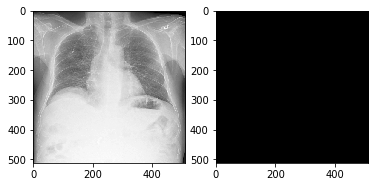

In [11]:
import matplotlib.pyplot as plt

# Check if training data looks all right
ix = random.randint(0, params['batch_size'])
f,ax = plt.subplots(1,2)
image, mask = train_generator.__getitem__(ix)
ax[0].imshow(np.squeeze(image[0]),cmap='gray')
ax[1].imshow(np.squeeze(mask[0]),cmap='gray')
plt.show()

In [12]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [13]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 160         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 512, 512, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [ ]:
# Fit model
history_callback = model.fit_generator(generator=train_generator, 
                                       validation_data=test_generator,
                                       epochs=50, shuffle=True, verbose=1)

acc_history = history_callback.history["acc"]
loss_history = history_callback.history["loss"]
val_acc_history = history_callback.history["val_acc"]
val_loss_history = history_callback.history["val_loss"]

Epoch 1/2


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:49: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


  2/670 [..............................] - ETA: 4:52:43 - loss: 0.6187 - mean_iou: 0.2388    

In [ ]:
with open('acc.txt', 'w') as f:
    for item in acc_history:
        f.write("%s\n" % item)
with open('loss.txt', 'w') as f:
    for item in loss_history:
        f.write("%s\n" % item)
with open('val_acc.txt', 'w') as f:
    for item in val_acc_history:
        f.write("%s\n" % item)
with open('val_loss.txt', 'w') as f:
    for item in val_loss_history:
        f.write("%s\n" % item)